In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

In [2]:
# pandas로 데이터 불러오기

train_df = pd.read_csv('./dataset/digit-recognizer/train.csv')
test_df = pd.read_csv('./dataset/digit-recognizer/test.csv')


# shape 확인

print('train_df.shape =', train_df.shape)
print('test_df.shape =', test_df.shape)

train_df.shape = (42000, 785)
test_df.shape = (28000, 784)


In [3]:
# 데이터 프레임 확인

train_df

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41996,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41997,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41998,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
# train data 정답과 이미지 분리
# data frame을 numpy array로 변환

y = train_df.iloc[:,0]
x = train_df.iloc[:,1:]

y = np.array(y)
x = np.array(x)

In [5]:
# train data와 validation data를 8:2 비율로 나누기

x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=36)

# train data 개수와 val data 개수 확인

print('length of x_train :', len(x_train))
print('length of x_val :', len(x_val))

length of x_train : 33600
length of x_val : 8400


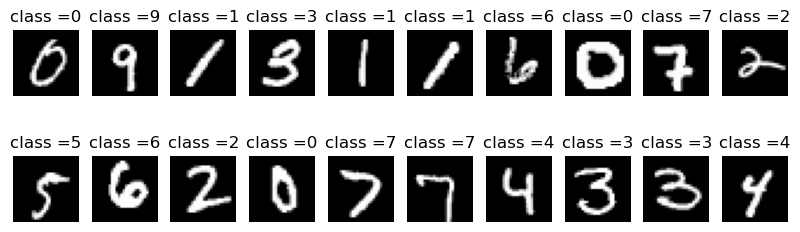

In [6]:
# x_train data 20개 시각화 및 y_train과 일치 여부 확인

import matplotlib.pyplot as plt

plt.figure(figsize=(10,3))
for i in range(20):
    plt.subplot(2,10,i+1)
    plt.axis('off')
    plt.imshow(x_train[i].reshape(28,28), cmap='gray')
    plt.title('class ='+str(y_train[i]))

In [7]:
# x_train, x_val shape을 28 * 28에 1채널(흑백)으로 변경

x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_val = x_val.reshape(x_val.shape[0], 28, 28, 1)

# shape 확인

print('x_train.shape :',x_train.shape)
print('x_val.shape :',x_val.shape)

x_train.shape : (33600, 28, 28, 1)
x_val.shape : (8400, 28, 28, 1)


In [8]:
# data_set 만들기 class 정의

from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as transforms
import torch


class MNIST_dataset(Dataset):
    def __init__(self, img, cls, transforms=None):
        self.img = img
        self.cls = cls
        self.transforms = transforms
        
    def __getitem__(self, idx):
        
        img = self.img[idx].astype('uint8')
        cls = self.cls[idx]
        
        if self.transforms is not None:
            img = self.transforms(img)

        return img, cls
    
    def __len__(self):
        return self.img.shape[0]
    

In [9]:
# 데이터 변형 설정

transforms_train = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((28, 28)),
    transforms.RandomRotation(20, fill=0) # train data는 랜덤하게 20도 이하를 뒤틀어줌. 튀틀리고 빈공간은 검은색으로 채움.
])

transforms_val = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((28, 28))
])

In [10]:
print(y_val.shape)
print(y_train.shape)

(8400,)
(33600,)


In [11]:
# 데이터 셋과 데이터로더 정의

train_dataset = MNIST_dataset(img=x_train, 
                             cls=y_train, 
                             transforms=transforms_train)
val_dataset = MNIST_dataset(img=x_val, 
                           cls=y_val, 
                           transforms=transforms_val)

train_dataloader = torch.utils.data.DataLoader(train_dataset, 
                                               batch_size=32, 
                                               shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, 
                                             batch_size=32,
                                             shuffle=False
                                            )

In [12]:


class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1,
                              out_channels=32,
                              kernel_size=2,
                              padding=1)
        self.bn = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(in_channels=32,
                              out_channels=32,
                              kernel_size=2,
                              padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2,
                                stride=2)
        self.fc1 = nn.Linear(7*7*32, 128)
        self.fc2 = nn.Linear(128, 32)
        self.fc3 = nn.Linear(32, 10)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn(x)
        x = F.relu(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.bn(x)
        x = F.relu(x)
        x = self.pool(x)
        
        x = x.view(-1, 7*7*32)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        x = F.log_softmax(x)
        return x

In [13]:
# device 설정, 노트북에 gpu가 없어서 cpu로 학습 진행 

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('device =', device)

# 경사 하강 방법 설정 및 손실 함수 정의

model = CNN().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.005, momentum=0.5)
criterion = nn.CrossEntropyLoss()

print(model)

device = cpu
CNN(
  (conv1): Conv2d(1, 32, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 32, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1568, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=10, bias=True)
)


In [14]:
# train 함수 정의

def train(model, train_loader, optimizer, log_interval):
    model.train()
    for batch_idx, (img, cls) in enumerate(train_loader):
        img = img.to(device)
        cls = cls.to(device)
        optimizer.zero_grad()
        output = model(img)
        loss = criterion(output, cls)
        loss.backward()
        optimizer.step()
        
        if batch_idx % log_interval == 0:
            print('train epoch : {} [{}/{} ({:.0f}%)] \t Train Loss : {:.6f}'.format(epoch, batch_idx*len(img),
                                                                                    len(train_loader.dataset), 
                                                                                     100. * batch_idx / len(train_loader),
                                                                                    loss.item()))

In [15]:
# validation 함수 정의

def evaluate(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    
    with torch.no_grad():
        for img, cls in test_loader:
            img = img.to(device)
            cls = cls.to(device)
            output = model(img)
            test_loss += criterion(output, cls).item()
            prediction = output.max(1, keepdim = True)[1]
            correct += prediction.eq(cls.view_as(prediction)).sum().item()
            
        test_loss /= len(test_loader.dataset)
        test_accuracy = 100. * correct / len(test_loader.dataset)
        return test_loss, test_accuracy

In [16]:
# 학습 진행

epochs = 50
for epoch in range(1, epochs + 1):
    train(model, train_dataloader, optimizer, log_interval=200)
    test_loss, test_accuracy = evaluate(model, val_dataloader)
    print('\n[epoch : {}], \t Test Loss : {:4f}, \t Test Accuracy : {:.2f}% \n'.format(epoch, test_loss, test_accuracy))

/var/folders/fl/lytw3yqx5913yh2tcxgw3d740000gn/T/ipykernel_13149/1141677918.py:35: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.log_softmax(x)


train epoch : 1 [0/33600 (0%)] 	 Train Loss : 2.331125
train epoch : 1 [6400/33600 (19%)] 	 Train Loss : 0.855980
train epoch : 1 [12800/33600 (38%)] 	 Train Loss : 0.379698
train epoch : 1 [19200/33600 (57%)] 	 Train Loss : 0.144905
train epoch : 1 [25600/33600 (76%)] 	 Train Loss : 0.268988
train epoch : 1 [32000/33600 (95%)] 	 Train Loss : 0.099724

[epoch : 1], 	 Test Loss : 0.018908, 	 Test Accuracy : 90.17% 

train epoch : 2 [0/33600 (0%)] 	 Train Loss : 0.424793
train epoch : 2 [6400/33600 (19%)] 	 Train Loss : 0.131150
train epoch : 2 [12800/33600 (38%)] 	 Train Loss : 0.155368
train epoch : 2 [19200/33600 (57%)] 	 Train Loss : 0.121221
train epoch : 2 [25600/33600 (76%)] 	 Train Loss : 0.085481
train epoch : 2 [32000/33600 (95%)] 	 Train Loss : 0.045416

[epoch : 2], 	 Test Loss : 0.024960, 	 Test Accuracy : 71.33% 

train epoch : 3 [0/33600 (0%)] 	 Train Loss : 0.067139
train epoch : 3 [6400/33600 (19%)] 	 Train Loss : 0.079179
train epoch : 3 [12800/33600 (38%)] 	 Train Loss

train epoch : 20 [19200/33600 (57%)] 	 Train Loss : 0.014382
train epoch : 20 [25600/33600 (76%)] 	 Train Loss : 0.088984
train epoch : 20 [32000/33600 (95%)] 	 Train Loss : 0.014331

[epoch : 20], 	 Test Loss : 0.021464, 	 Test Accuracy : 77.62% 

train epoch : 21 [0/33600 (0%)] 	 Train Loss : 0.012596
train epoch : 21 [6400/33600 (19%)] 	 Train Loss : 0.033228
train epoch : 21 [12800/33600 (38%)] 	 Train Loss : 0.022487
train epoch : 21 [19200/33600 (57%)] 	 Train Loss : 0.007866
train epoch : 21 [25600/33600 (76%)] 	 Train Loss : 0.003317
train epoch : 21 [32000/33600 (95%)] 	 Train Loss : 0.033102

[epoch : 21], 	 Test Loss : 0.028160, 	 Test Accuracy : 66.31% 

train epoch : 22 [0/33600 (0%)] 	 Train Loss : 0.003805
train epoch : 22 [6400/33600 (19%)] 	 Train Loss : 0.061834
train epoch : 22 [12800/33600 (38%)] 	 Train Loss : 0.003900
train epoch : 22 [19200/33600 (57%)] 	 Train Loss : 0.332051
train epoch : 22 [25600/33600 (76%)] 	 Train Loss : 0.003154
train epoch : 22 [32000/33

train epoch : 39 [32000/33600 (95%)] 	 Train Loss : 0.034649

[epoch : 39], 	 Test Loss : 0.021483, 	 Test Accuracy : 77.32% 

train epoch : 40 [0/33600 (0%)] 	 Train Loss : 0.024683
train epoch : 40 [6400/33600 (19%)] 	 Train Loss : 0.004556
train epoch : 40 [12800/33600 (38%)] 	 Train Loss : 0.079330
train epoch : 40 [19200/33600 (57%)] 	 Train Loss : 0.016332
train epoch : 40 [25600/33600 (76%)] 	 Train Loss : 0.016346
train epoch : 40 [32000/33600 (95%)] 	 Train Loss : 0.001854

[epoch : 40], 	 Test Loss : 0.020131, 	 Test Accuracy : 78.44% 

train epoch : 41 [0/33600 (0%)] 	 Train Loss : 0.001344
train epoch : 41 [6400/33600 (19%)] 	 Train Loss : 0.005596
train epoch : 41 [12800/33600 (38%)] 	 Train Loss : 0.056409
train epoch : 41 [19200/33600 (57%)] 	 Train Loss : 0.010640
train epoch : 41 [25600/33600 (76%)] 	 Train Loss : 0.005268
train epoch : 41 [32000/33600 (95%)] 	 Train Loss : 0.019476

[epoch : 41], 	 Test Loss : 0.022429, 	 Test Accuracy : 76.01% 

train epoch : 42 [0/3

In [18]:
# 데이터 셋을 맞추기 위해 cls column 추가

test_df['cls'] = 0
test_df

# 이미지, 정답 분리 및 numpy array로 변환, reshape

x_test = test_df.iloc[:, 0:-1]
y_test = test_df.iloc[:, -1]

x_test = np.array(x_test)
x_test = x_test.reshape(-1, 28,28,1)

In [19]:
# dataset 및 dataloader 정의

test_dataset = MNIST_dataset(img=x_test, cls=y_test, transforms=transforms_val)

test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

In [20]:
# 예측

final_preds = []

def predict(model, dataloader, device):
    model.eval()
    
    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs = inputs.to(device)
            targets = targets.to(device)
            
            outputs = model(inputs)
            
            _, preds = torch.max(outputs, 1)
            preds = preds.cpu().data.numpy()
            
            final_preds.extend(preds)
            
predict(model, test_dataloader, device)

print(len(final_preds))
print(final_preds)

/var/folders/fl/lytw3yqx5913yh2tcxgw3d740000gn/T/ipykernel_13149/1141677918.py:35: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.log_softmax(x)


28000
[2, 0, 9, 0, 2, 7, 0, 3, 0, 3, 5, 2, 4, 0, 4, 8, 3, 1, 7, 0, 7, 1, 1, 5, 7, 4, 2, 7, 7, 7, 7, 4, 4, 2, 6, 2, 8, 5, 1, 5, 7, 7, 4, 9, 2, 7, 2, 2, 1, 7, 6, 8, 8, 3, 8, 2, 1, 2, 2, 3, 2, 1, 7, 0, 0, 0, 1, 2, 0, 1, 6, 3, 8, 2, 2, 9, 3, 7, 2, 3, 5, 7, 1, 0, 9, 2, 4, 3, 6, 7, 2, 0, 6, 6, 1, 4, 3, 9, 7, 4, 0, 7, 2, 7, 7, 3, 0, 5, 2, 8, 0, 0, 4, 2, 1, 7, 2, 1, 3, 2, 3, 7, 2, 8, 6, 3, 8, 7, 7, 4, 3, 5, 1, 7, 0, 0, 3, 1, 3, 6, 4, 3, 4, 5, 5, 2, 7, 7, 2, 8, 4, 3, 5, 8, 5, 2, 7, 3, 7, 8, 3, 2, 4, 5, 1, 2, 7, 6, 3, 0, 2, 7, 7, 6, 1, 3, 7, 4, 1, 2, 4, 2, 5, 2, 4, 7, 2, 1, 6, 0, 6, 1, 4, 9, 6, 0, 9, 7, 6, 9, 1, 7, 0, 9, 9, 0, 2, 4, 6, 2, 0, 7, 3, 6, 3, 2, 1, 6, 3, 4, 2, 2, 2, 2, 2, 0, 4, 6, 1, 0, 0, 4, 7, 1, 7, 3, 2, 3, 2, 6, 8, 6, 2, 8, 5, 5, 4, 8, 2, 4, 9, 7, 1, 3, 8, 4, 8, 1, 4, 3, 6, 3, 3, 5, 7, 0, 6, 8, 3, 1, 6, 0, 6, 3, 2, 3, 1, 5, 8, 4, 0, 7, 2, 5, 3, 3, 7, 1, 9, 2, 8, 7, 7, 9, 9, 6, 3, 0, 3, 3, 6, 9, 8, 2, 2, 2, 7, 1, 4, 3, 2, 5, 9, 0, 0, 3, 8, 4, 1, 8, 4, 1, 1, 4, 2, 4, 3, 1, 3, 3, 6, 

In [21]:
submission = pd.read_csv('./dataset/digit-recognizer/sample_submission.csv')
submission['Label'] = final_preds
submission.to_csv('./dataset/digit-recognizer/submission_CNN.csv', index=False)
submission.head(10)

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,0
4,5,2
5,6,7
6,7,0
7,8,3
8,9,0
9,10,3


(-0.5, 964.5, 186.5, -0.5)

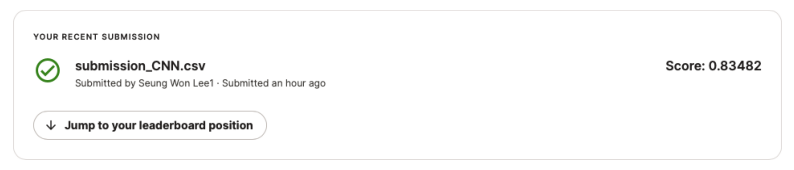

In [22]:
import cv2
score = cv2.imread('./dataset/digit-recognizer/CNN.png')
plt.figure(figsize=(10,2))
plt.imshow(score, cmap='gray')
plt.axis('off')